# Interactive Integration of the MCO
## For the Mechanical Chaotic Oscillator
```
Michael Huster
Duquesne University
profhuster@gmail.com
2019-07-10
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import numba
%matplotlib inline

In [2]:
# From https://pundit.pratt.duke.edu/wiki/Python:Ordinary_Differential_Equations/Examples
def state_plotter(times, states, fig_num):
    num_states = np.shape(states)[0]
    num_cols = int(np.ceil(np.sqrt(num_states)))
    num_rows = int(np.ceil(num_states / num_cols))
    plt.figure(fig_num, figsize=(12,6))
    plt.clf()
    fig, ax = plt.subplots(num_rows, num_cols, num=fig_num, clear=True,
                         squeeze=False)
    for n in range(num_states):
        row = n // num_cols
        col = n % num_cols
        ax[row][col].plot(times, states[n], 'b,')
        ax[row][col].set(xlabel='Time',
                         ylabel='$y_{:0.0f}(t)$'.format(n),
                         title='$y_{:0.0f}(t)$ vs. Time'.format(n))
        
    for n in range(num_states, num_rows * num_cols):
        fig.delaxes(ax[n // num_cols][n % num_cols])

    fig.tight_layout()
    return fig

# MCO - Mechanical Chaotic Oscillator
## Numerical Integration

The Newton's Second Law equation of motion are

$$
\omega_{\phi} = \dot{\phi}
$$

and

$$
\dot{\omega}_{\phi} = -\frac{\mu}{I}\left [ B_{field} \sin \phi + 
B_{drive} \cos \phi \sin \omega_d t \right ] - \frac{\beta 
\omega_{\phi}}{I}
$$

I define $\omega_0^2 = \frac{\mu B_{field}}{I}$, $b = \frac{B_{drive}}{B_{field}}$ and 
$\gamma = \frac{\beta}{I}$,
then the equation of the MCO can be written

$$
\dot{\omega}_{\phi} = -\omega_0^2 \left [
\sin \phi + b \cos \phi \sin \omega_d t \right ] 
- \gamma \omega_{\phi}
$$

# Global Integration Parameters

In [3]:
# Globals
N_CYCLES = 100
POINTS_PER_CYCLE = 30
OMEGA_0 = 1.0
OMEGA_D = 0.8 * OMEGA_0
b = 0.0
GAMMA = 0.00
PHI0 = 0.1 * np.pi

# Derived globals
nPoints = N_CYCLES * POINTS_PER_CYCLE

T_DRIVE = 2.0 * np.pi / OMEGA_D
DT = T_DRIVE / POINTS_PER_CYCLE
DT2 = DT * DT

OMEGA_0_SQ = OMEGA_0**2
print(f"Tdr={T_DRIVE:.4e}s, DT={DT:.4e}s, nP={nPoints}, Osq={OMEGA_0_SQ:.4e}")

Tdr=7.8540e+00s, DT=2.6180e-01s, nP=3000, Osq=1.0000e+00


# Velocity Verlet Integration

In [7]:
@numba.jit
def velocityVerlet(i, y, t):
    accHalf = -OMEGA_0_SQ * (np.sin(y[0,i]) + b * np.cos(y[0,i]) * np.sin(OMEGA_D * t[i])) - \
      GAMMA * y[1,i]
    y[0,i+1] = y[0,i] + y[1,i] * DT + 0.5 * accHalf * DT2
    accFull = -OMEGA_0_SQ * (np.sin(y[0,i+1]) + b * np.cos(y[0,i+1]) * np.sin(OMEGA_D * t[i+1])) - \
      GAMMA * y[1,i]
    y[1,i+1] = y[1,i] + 0.5 * (accHalf + accFull) * DT

In [12]:
y=0
t=0

#@numba.jit(nopython=True)
def modelMCO(nCycles=10, log10Gamma=-6.0, log10B=-6):
    global t, y, DT, OMEGA_0_SQ, b, OMEGA_D, GAMMA, PHI0, POINTS_PER_CYCLE
    # Use function parameters
    nPoints = nCycles * POINTS_PER_CYCLE
    if log10Gamma <= -5.99:
        GAMMA = 0.0
    else:
        GAMMA = 10.0**log10Gamma
    if log10B <= -5.99:
        b = 0.0
    else:
        b = 10.0**log10B

    t = np.arange(0, nPoints * DT, DT)
    #print(t, t[-1]+DT)
    y = np.zeros((2,nPoints), dtype='float64')
    y[0,0] = PHI0
    y[0,1] = 0.0

    # Run
    for i in range(nPoints-1):
        velocityVerlet(i, y, t)

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.plot((y[0]+np.pi)%(2*np.pi), y[1], 'b,')
    ax.plot((y[0,0:nPoints:POINTS_PER_CYCLE]+np.pi)%(2*np.pi), y[1,0:nPoints:POINTS_PER_CYCLE], 'k.', ms=2.0)
    ax.plot(ax.get_xlim(),(0,0), 'r-', lw=0.5)
    ax.plot((np.pi,np.pi),ax.get_ylim(), 'r-', lw=0.5)
    ax.axis('equal')
    ax.set_xlabel('$\phi$')
    ax.set_ylabel('$\omega_{\phi}$')
    ax.set_title("Ncycles={}, $\gamma$={}, b={}, Od/Os={:.2f}".format(nCycles, GAMMA, b, OMEGA_D/OMEGA_0))
    # xText = ax.get_xlim()[1]
    # yText = ax.get_ylim()[1]
    # ax.text(xText, yText,'Hello')
    plt.show()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.11 µs


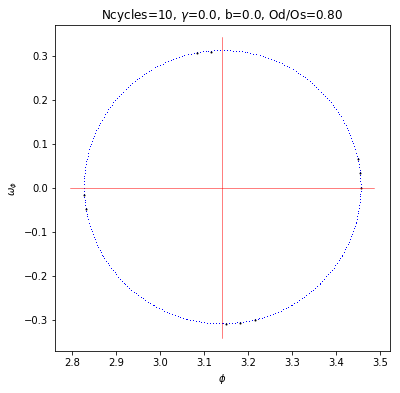

In [13]:
%time
jnk = modelMCO()

In [14]:
# Interactive call
interact(modelMCO, nCycles=(1,10000), log10Gamma=(-6,1), log10B=(-6,1));

interactive(children=(IntSlider(value=10, description='nCycles', max=10000, min=1), IntSlider(value=-6, descri…

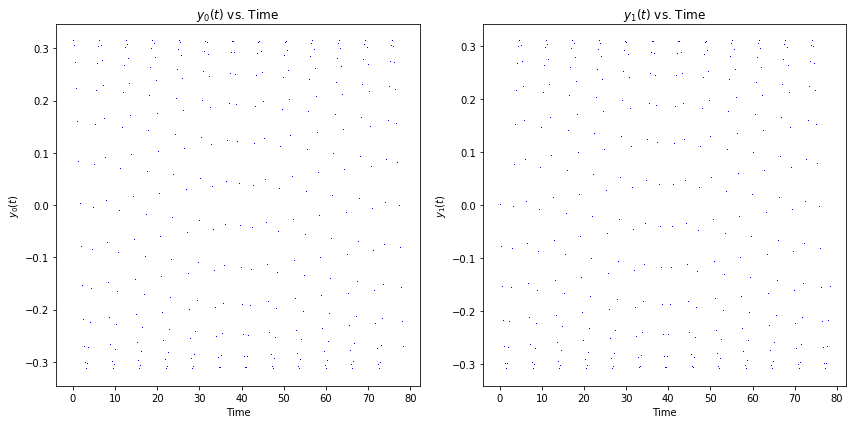

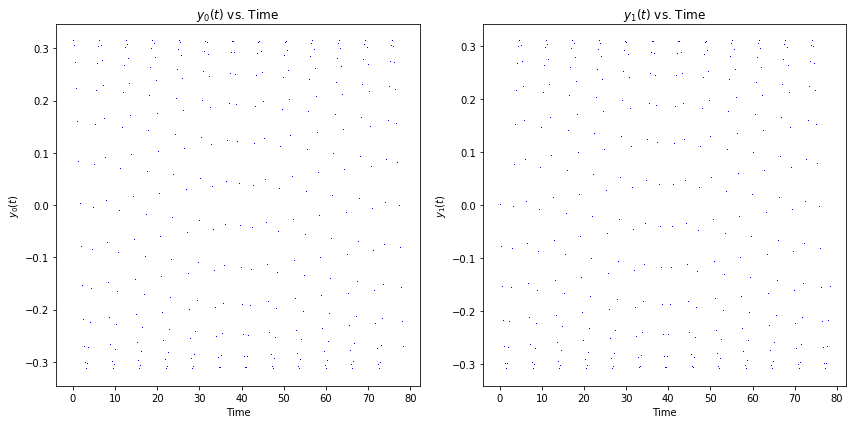

In [9]:
state_plotter(t, y, 1)

# Euler-Cromer (Symplectic Euler)

In [10]:
def symEuler(i, y, t):
    # Update p
    # For this system, I can solve the implicit equation for omega[i+1]
    y[1,i+1] = y[1,i] * (1.0 - GAMMA * DT) - \
        DT * OMEGA_0_SQ * (np.sin(y[0,i]) + b * np.cos(y[0,i]) * np.sin(OMEGA_D * t[i]))
    y[0,i+1] = y[0,i] + DT * y[1,i+1]